In [1]:
import pathlib
import sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tqdm

sys.path.append("../helpers")

## load data

In [2]:
# load data
cls_file_path = pathlib.Path(
    "../../1.scDINO_analysis/1.scDINO_run/outputdir/mnist_photos/CLS_features/channel_binary_model_dino_deitsmall16_pretrain_full_checkpoint_features.csv"
).resolve(strict=True)

image_paths_file_path = pathlib.Path(
    "../../1.scDINO_analysis/1.scDINO_run/outputdir/mnist_photos/CLS_features/image_paths.csv"
).resolve(strict=True)

# load in the image paths
image_paths = pd.read_csv(image_paths_file_path, header=None)
print(image_paths.shape)

# load in the the data to a csv
cls_features = pd.read_csv(cls_file_path, header=None)
print(cls_features.shape)
cls_features.head()

(5000, 1)
(5000, 384)


,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.036020,-0.069563,0.020114,-0.029239,0.072019,0.047018,-0.026606,-0.041189,0.010700,0.073829,...,0.020264,0.065846,-0.031214,0.009239,0.039789,-0.009602,0.079215,0.082336,0.050896,0.043353
1,-0.015554,-0.119414,0.049191,-0.050084,0.110552,0.052202,-0.028008,-0.004395,0.041069,0.029579,...,0.024089,0.047773,0.001866,0.012299,-0.000628,0.025607,0.075623,0.085243,0.014932,0.004105
2,-0.015430,-0.112885,0.048210,-0.060197,0.133900,0.049964,-0.029808,-0.013767,0.038313,0.016041,...,0.028545,0.050983,0.022572,0.022108,-0.000868,0.044039,0.059312,0.076754,0.004232,-0.003868
3,-0.015230,-0.123356,0.033107,-0.064654,0.091878,0.032948,-0.026383,-0.006345,0.060116,0.011472,...,0.029440,0.064373,0.006904,0.013025,-0.010061,0.043078,0.075610,0.089637,-0.009439,0.004538
4,-0.003228,-0.152239,0.041797,-0.070456,0.057250,0.012942,-0.034990,-0.020237,0.074116,0.012684,...,0.036741,0.057769,0.000899,0.002931,-0.003383,0.048216,0.058638,0.117410,-0.015315,0.014614


In [3]:
# rename columns
cls_features.columns = [f"CLS_{i}" for i in range(cls_features.shape[1])]
cls_features.head()

,CLS_0,CLS_1,CLS_2,CLS_3,CLS_4,CLS_5,CLS_6,CLS_7,CLS_8,CLS_9,...,CLS_374,CLS_375,CLS_376,CLS_377,CLS_378,CLS_379,CLS_380,CLS_381,CLS_382,CLS_383
0,-0.036020,-0.069563,0.020114,-0.029239,0.072019,0.047018,-0.026606,-0.041189,0.010700,0.073829,...,0.020264,0.065846,-0.031214,0.009239,0.039789,-0.009602,0.079215,0.082336,0.050896,0.043353
1,-0.015554,-0.119414,0.049191,-0.050084,0.110552,0.052202,-0.028008,-0.004395,0.041069,0.029579,...,0.024089,0.047773,0.001866,0.012299,-0.000628,0.025607,0.075623,0.085243,0.014932,0.004105
2,-0.015430,-0.112885,0.048210,-0.060197,0.133900,0.049964,-0.029808,-0.013767,0.038313,0.016041,...,0.028545,0.050983,0.022572,0.022108,-0.000868,0.044039,0.059312,0.076754,0.004232,-0.003868
3,-0.015230,-0.123356,0.033107,-0.064654,0.091878,0.032948,-0.026383,-0.006345,0.060116,0.011472,...,0.029440,0.064373,0.006904,0.013025,-0.010061,0.043078,0.075610,0.089637,-0.009439,0.004538
4,-0.003228,-0.152239,0.041797,-0.070456,0.057250,0.012942,-0.034990,-0.020237,0.074116,0.012684,...,0.036741,0.057769,0.000899,0.002931,-0.003383,0.048216,0.058638,0.117410,-0.015315,0.014614


In [4]:
# rename the image paths columns
image_paths.columns = ["Metadata_image_paths"]
# make metadata columns for the image paths
cls_features["Metadata_label"] = image_paths["Metadata_image_paths"].apply(
    lambda x: pathlib.Path(x).stem.split("_")[1]
)
cls_features["Metadata_cell_idx"] = image_paths["Metadata_image_paths"].apply(
    lambda x: pathlib.Path(x).stem.split("_")[3]
)
cls_features["Metadata_Time"] = image_paths["Metadata_image_paths"].apply(
    lambda x: pathlib.Path(x).stem.split("_")[5]
)
# reorder the columns so that the metadata columns are first
cls_features = cls_features[
    ["Metadata_label", "Metadata_cell_idx", "Metadata_Time"]
    + cls_features.columns[:-3].tolist()
]

# make all columns floats
cls_features = cls_features.astype(float)
cls_features.head()

,Metadata_label,Metadata_cell_idx,Metadata_Time,CLS_0,CLS_1,CLS_2,CLS_3,CLS_4,CLS_5,CLS_6,...,CLS_374,CLS_375,CLS_376,CLS_377,CLS_378,CLS_379,CLS_380,CLS_381,CLS_382,CLS_383
0,6.0,112.0,0.0,-0.036020,-0.069563,0.020114,-0.029239,0.072019,0.047018,-0.026606,...,0.020264,0.065846,-0.031214,0.009239,0.039789,-0.009602,0.079215,0.082336,0.050896,0.043353
1,6.0,112.0,1.0,-0.015554,-0.119414,0.049191,-0.050084,0.110552,0.052202,-0.028008,...,0.024089,0.047773,0.001866,0.012299,-0.000628,0.025607,0.075623,0.085243,0.014932,0.004105
2,6.0,112.0,2.0,-0.015430,-0.112885,0.048210,-0.060197,0.133900,0.049964,-0.029808,...,0.028545,0.050983,0.022572,0.022108,-0.000868,0.044039,0.059312,0.076754,0.004232,-0.003868
3,6.0,112.0,3.0,-0.015230,-0.123356,0.033107,-0.064654,0.091878,0.032948,-0.026383,...,0.029440,0.064373,0.006904,0.013025,-0.010061,0.043078,0.075610,0.089637,-0.009439,0.004538
4,6.0,112.0,4.0,-0.003228,-0.152239,0.041797,-0.070456,0.057250,0.012942,-0.034990,...,0.036741,0.057769,0.000899,0.002931,-0.003383,0.048216,0.058638,0.117410,-0.015315,0.014614


In [5]:
cls_tensor = torch.tensor(cls_features.iloc[:, 3:].values)
# reshape the data from (cell_idx, time, features) to (cell_idx, features*time)
print(cls_tensor.shape)
cls_tensor = torch.tensor(cls_features.iloc[:, 3:].values)
cls_tensor = cls_tensor.reshape(
    -1, cls_features.Metadata_Time.nunique(), cls_tensor.shape[1]
)

print(cls_tensor.shape)

torch.Size([5000, 384])
torch.Size([1000, 5, 384])


In [6]:
import torch.nn

# make a Dataset
import torch.utils


class CLSDataset(torch.utils.data.Dataset):
    def __init__(self, cls_features: pd.DataFrame):
        super(CLSDataset, self).__init__()
        self.cls_features = cls_features

    def __len__(self):
        return self.cls_features.shape[0]

    @staticmethod
    def mask_timepoints(tensor: torch.Tensor, timepoints: int):
        # mask one timepoint in the tensor
        # random value from 0 to timepoints
        random_timepoint = np.random.randint(0, timepoints)
        tensor[random_timepoint, :] = 1
        return tensor

    def __getitem__(self, idx):
        y = self.cls_features[idx, :, :]
        x = self.mask_timepoints(y, y.shape[0])
        return x, y


# make a DataLoader
cls_dataset = CLSDataset(cls_tensor)
cls_loader = torch.utils.data.DataLoader(cls_dataset, batch_size=20, shuffle=False)
# get the first batch size
x, y = next(iter(cls_loader))
x.shape, y.shape

(torch.Size([20, 5, 384]), torch.Size([20, 5, 384]))

## Define the model

Code adapted from https://medium.com/correll-lab/building-a-vision-transformer-model-from-scratch-a3054f707cc6

In [7]:
class PositionWiseEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(
            torch.randn(1, 1, d_model)
        )  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length + 1, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = torch.sin(
                        pos / 10000 ** (2 * i / torch.tensor(d_model))
                    )
                else:
                    pe[pos][i] = torch.cos(
                        pos / 10000 ** (2 * i / torch.tensor(d_model))
                    )

        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe[:, : x.size(1), :]

        return x


# test the PositionWiseEncoding
d_model = torch.tensor(512)
max_seq_length = torch.tensor(10)
pe = PositionWiseEncoding(d_model, max_seq_length)
pe.forward(torch.randn(2, 10, 512))

/tmp/ipykernel_1590240/3781259385.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos / 10000 ** (2 * i / torch.tensor(d_model))
/tmp/ipykernel_1590240/3781259385.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos / 10000 ** (2 * i / torch.tensor(d_model))


tensor([[[ 0.4259,  0.7789, -1.6346,  ..., -0.6351, -1.3860,  0.0758],
         [-0.7108,  2.5213, -0.1028,  ...,  0.1362, -0.1611,  0.8391],
         [ 2.0931,  0.0859,  0.9316,  ...,  2.6196, -1.0488,  0.6091],
         ...,
         [-0.0065, -0.4721, -0.2059,  ...,  0.8734, -1.0588, -0.1436],
         [ 1.8491, -0.5475,  1.9223,  ...,  0.7012, -0.2864,  3.9503],
         [ 0.2775, -0.4338, -0.2313,  ..., -1.1143,  2.0014,  0.1231]],

        [[ 0.4259,  0.7789, -1.6346,  ..., -0.6351, -1.3860,  0.0758],
         [ 1.8208, -0.2064,  0.4865,  ...,  2.0411,  0.4787,  2.2664],
         [-0.5524, -0.8080,  1.7158,  ...,  0.2561, -1.1889,  0.8980],
         ...,
         [ 0.3944,  1.1028,  0.4091,  ...,  1.9191,  1.5585,  0.8418],
         [ 0.5198, -0.2703, -0.0588,  ...,  0.7778, -0.7784,  2.0941],
         [ 0.8312,  0.1387,  1.3370,  ..., -0.1252,  1.2502, -0.0794]]],
       grad_fn=<AddBackward0>)

In [8]:
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        # Obtaining Queries, Keys, and Values
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Dot Product of Queries and Keys
        attention = Q @ K.transpose(-2, -1)

        # Scaling
        attention = attention / (self.head_size**0.5)

        attention = torch.softmax(attention, dim=-1)

        attention = attention @ V

        return attention


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.head_size = d_model // n_heads

        self.W_o = nn.Linear(d_model, d_model)

        self.heads = nn.ModuleList(
            [AttentionHead(d_model, self.head_size) for _ in range(n_heads)]
        )

    def forward(self, x):
        # Combine attention heads
        out = torch.cat([head(x) for head in self.heads], dim=-1)

        out = self.W_o(out)

        return out


# test the MultiHeadAttention
d_model = torch.tensor(512)
n_heads = torch.tensor(8)
mha = MultiHeadAttention(d_model, n_heads)
mha.forward(torch.randn(2, 10, 512))

tensor([[[ 0.1482,  0.2814,  0.0103,  ..., -0.1836,  0.1460, -0.0406],
         [ 0.1597,  0.3344,  0.1091,  ..., -0.1833,  0.1337,  0.0167],
         [ 0.1305,  0.2773,  0.1293,  ..., -0.1540,  0.1392,  0.0473],
         ...,
         [ 0.1877,  0.2653,  0.0591,  ..., -0.0771,  0.1759,  0.1538],
         [ 0.1296,  0.3634,  0.0778,  ..., -0.1345,  0.1647,  0.0633],
         [ 0.1628,  0.2223,  0.0612,  ..., -0.1458,  0.1268, -0.0211]],

        [[-0.0513,  0.1554, -0.0321,  ...,  0.1578, -0.0472,  0.0347],
         [-0.0080,  0.0631,  0.1177,  ...,  0.1883, -0.0703, -0.0130],
         [-0.0266,  0.1080,  0.0243,  ...,  0.1512, -0.0725,  0.0056],
         ...,
         [-0.0295,  0.1125,  0.0437,  ...,  0.1254, -0.0550,  0.0442],
         [ 0.0194,  0.1485, -0.0229,  ...,  0.1656, -0.0598,  0.0842],
         [-0.0259,  0.0362, -0.0066,  ...,  0.1895, -0.0542,  0.0271]]],
       grad_fn=<ViewBackward0>)

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model),
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out


# test the TransformerEncoder
d_model = 384
n_heads = 8
r_mlp = 4
te = TransformerEncoder(d_model, n_heads, r_mlp)
te.forward(torch.randn(2, 10, 384, dtype=torch.float32))

tensor([[[ 0.0517,  0.4633, -0.7959,  ...,  0.8390, -0.6796,  0.0632],
         [-1.0381,  0.0995,  1.3506,  ..., -1.2691,  0.7742, -0.4533],
         [ 0.5199, -0.2791, -0.6361,  ..., -0.1948,  0.4911,  0.7388],
         ...,
         [-0.3387,  0.8123, -0.2163,  ...,  0.5485, -2.0584, -0.1170],
         [ 1.3885, -1.0559, -0.7760,  ...,  1.0232, -0.3935,  0.7358],
         [-1.0976,  0.5326, -0.4174,  ...,  1.2696,  0.5474,  2.3205]],

        [[-0.4360,  0.8441, -1.4271,  ...,  0.5491, -0.2153, -0.8788],
         [-1.0141,  1.8183, -0.3503,  ..., -2.0212,  0.9445, -0.6243],
         [-0.7893,  0.1897, -0.9058,  ...,  0.6452, -1.4582, -1.2370],
         ...,
         [ 0.0660, -1.0965, -1.1706,  ...,  0.8021, -0.8539,  0.6417],
         [ 0.4265, -1.2183, -0.2793,  ..., -0.0356,  0.5919,  0.6208],
         [-0.9355, -0.0613, -0.0394,  ..., -0.0882,  0.4529, -0.1441]]],
       grad_fn=<AddBackward0>)

In [10]:
class TemporalTransformer(nn.Module):
    def __init__(self, d_model, n_classes, n_heads, n_layers, seq_len):
        super().__init__()

        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.n_heads = n_heads  # Number of attention heads
        self.seq_len = seq_len  # Sequence length

        self.positional_encoding = PositionWiseEncoding(self.d_model, self.seq_len)
        self.transformer_encoder = nn.Sequential(
            *[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)]
        )

        # Classification MLP
        self.classifier = nn.Sequential(
            nn.Linear(self.d_model, self.n_classes), nn.Softmax(dim=-1)
        )

    def forward(self, x):

        x = self.positional_encoding(x)

        x = self.transformer_encoder(x)

        # x = self.classifier(x[:,0])
        # remove the class token
        x = x[:, 1:, :]

        return x


# test the Transformer
d_model = 384
n_classes = 10
n_heads = 8
n_layers = 4
seq_len = 10
tt = TemporalTransformer(d_model, n_classes, n_heads, n_layers, seq_len)
tt.forward(torch.randn(2, 10, 384))

tensor([[[ 3.7971e-01,  1.3478e+00, -7.2694e-02,  ...,  9.8924e-01,
           5.5410e-01, -2.5646e-01],
         [ 3.5822e+00, -8.3564e-01,  1.0840e-01,  ...,  8.1779e-01,
           3.7615e-01, -2.1537e-01],
         [-1.7568e-01,  3.3929e-01, -1.4638e+00,  ...,  1.4832e+00,
          -1.4992e-01,  4.4022e-01],
         ...,
         [ 9.0873e-01, -1.5025e+00, -1.6197e+00,  ...,  2.0764e+00,
           1.1883e+00,  2.4522e+00],
         [ 1.0783e+00, -1.0667e+00, -4.7815e-04,  ...,  1.0726e+00,
           6.2300e-01,  1.8167e+00],
         [ 1.8559e+00,  6.7621e-01, -2.6584e+00,  ...,  2.0782e+00,
           1.8877e+00,  1.4302e+00]],

        [[ 3.1250e+00,  1.5772e+00,  4.5252e-01,  ...,  1.2117e+00,
           9.9584e-02,  9.8623e-01],
         [ 1.4129e+00,  1.2113e+00, -2.9658e-01,  ...,  2.4330e+00,
           8.5276e-01, -1.3897e-01],
         [-3.0406e-01, -1.0975e+00, -8.7351e-01,  ...,  3.0576e+00,
           1.2604e-01,  2.0688e+00],
         ...,
         [ 1.8611e+00,  1

## Test the model

In [11]:
d_model = 384
n_classes = 10
n_heads = 12
n_layers = 8
batch_size = 32
epochs = 150
alpha = 0.05

seq_len = 5
# training data loader is cls_loader

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    "Using device: ",
    device,
    f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "",
)

transformer = TemporalTransformer(d_model, n_classes, n_heads, n_layers, seq_len).to(
    device
)
# import adam
from torch.optim import Adam

optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.MSELoss()

for epoch in range(epochs):

    training_loss = 0.0
    for i, data in enumerate(cls_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        optimizer.zero_grad()
        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs} loss: {training_loss  / len(cls_loader) :.3f}")

Using device:  cuda (NVIDIA GeForce RTX 3090 Ti)
Epoch 1/150 loss: 581589.130
Epoch 2/150 loss: 23364.721
Epoch 3/150 loss: 1580.872
Epoch 4/150 loss: 796.613
Epoch 5/150 loss: 603.941
Epoch 6/150 loss: 324.263
Epoch 7/150 loss: 425.097
Epoch 8/150 loss: 173.581
Epoch 9/150 loss: 2520.767
Epoch 10/150 loss: 1147.356
Epoch 11/150 loss: 161.971
Epoch 12/150 loss: 90.323
Epoch 13/150 loss: 50.909
Epoch 14/150 loss: 60.877
Epoch 15/150 loss: 46.791
Epoch 16/150 loss: 37.890
Epoch 17/150 loss: 86.390
Epoch 18/150 loss: 142.229
Epoch 19/150 loss: 221.102
Epoch 20/150 loss: 254.276
Epoch 21/150 loss: 300353038.049
Epoch 22/150 loss: 115105856.760
Epoch 23/150 loss: 10170859.785
Epoch 24/150 loss: 305837.461
Epoch 25/150 loss: 109102.606
Epoch 26/150 loss: 78004.818
Epoch 27/150 loss: 64421.959
Epoch 28/150 loss: 54044.481
Epoch 29/150 loss: 44312.993
Epoch 30/150 loss: 37690.809
Epoch 31/150 loss: 32899.131
Epoch 32/150 loss: 28597.200
Epoch 33/150 loss: 24928.859
Epoch 34/150 loss: 21113.332

In [13]:
list_of_reconstructed = []
list_of_original = []
with torch.no_grad():
    for data in cls_loader:
        x, y = data
        x, y = x.to(device).float(), y.to(device).float()

        # reshape (B, T, d) -> (B*T, d)
        x = transformer(x)
        x = x.reshape(-1, x.shape[-1])
        y = y.reshape(-1, y.shape[-1])
        list_of_reconstructed.append(x.cpu().numpy())
        list_of_original.append(y.cpu().numpy())

In [14]:
# make two different dfs for the reconstructed and original data
reconstructed_df = pd.DataFrame(np.concatenate(list_of_reconstructed))
original_df = pd.DataFrame(np.concatenate(list_of_original))

# add the metadata columns
reconstructed_df = pd.concat([cls_features.iloc[:, :3], reconstructed_df], axis=1)
original_df = pd.concat([cls_features.iloc[:, :3], original_df], axis=1)

# add label for reconstructed and original
reconstructed_df["Metadata_reconstructed"] = "reconstructed_df"
original_df["Metadata_reconstructed"] = "original_df"

# combine the two dataframes
combined_df = pd.concat([reconstructed_df, original_df])
combined_df.head()
# rename columns if int columns
combined_df.rename(
    columns={
        col: f"CLS_{col}" if isinstance(col, int) else col
        for col in combined_df.columns
    },
    inplace=True,
)
# metadata columns
metadata_columns = [col for col in combined_df.columns if "Metadata" in col]
combined_df.reset_index(drop=True, inplace=True)
features_df = combined_df.drop(metadata_columns, axis=1)

features_df.head()

,CLS_0,CLS_1,CLS_2,CLS_3,CLS_4,CLS_5,CLS_6,CLS_7,CLS_8,CLS_9,...,CLS_374,CLS_375,CLS_376,CLS_377,CLS_378,CLS_379,CLS_380,CLS_381,CLS_382,CLS_383
0,0.832764,2.062256,0.580078,1.965332,1.045898,1.492676,0.866211,2.266113,1.530029,0.777832,...,1.320557,1.680420,0.697998,-0.724609,0.876221,0.669922,0.917969,1.136719,0.664551,0.340820
1,0.896240,1.167603,0.768555,1.157227,1.313477,0.800293,1.184570,1.687012,1.874512,0.263184,...,1.313232,1.677490,0.707031,-0.706055,0.888062,0.676758,0.923340,1.141602,0.674805,0.361816
2,0.135010,0.543640,0.208008,0.468750,0.940430,0.109375,0.973633,1.033875,1.768066,-0.366699,...,1.298584,1.663330,0.714600,-0.696289,0.896240,0.682617,0.928223,1.162109,0.666992,0.381836
3,-0.751709,0.717163,-0.669922,0.386719,0.170898,-0.168457,0.346680,0.626465,1.260498,-0.856934,...,1.284424,1.647217,0.719727,-0.696777,0.897949,0.685547,0.936035,1.180664,0.648438,0.389648
4,3.894775,0.502197,4.109375,1.021729,1.514648,2.780273,1.641602,-0.608826,-1.447021,5.187012,...,-0.218750,-1.671387,2.155273,7.831055,1.436646,2.286133,1.294434,0.376465,2.350098,3.525879


In [15]:
# umap
import umap

reducer = umap.UMAP(n_neighbors=15, n_components=2, metric="euclidean")
embedding = reducer.fit_transform(features_df)
embedding_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
embedding_df["Metadata_reconstructed"] = combined_df["Metadata_reconstructed"]
embedding_df["Metadata_label"] = combined_df["Metadata_label"]
embedding_df["Metadata_cell_idx"] = combined_df["Metadata_cell_idx"]
embedding_df.head()

/home/lippincm/miniforge3/envs/transformers_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lippincm/miniforge3/envs/transformers_env/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/lippincm/miniforge3/envs/transformers_env/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


,UMAP1,UMAP2,Metadata_reconstructed,Metadata_label,Metadata_cell_idx
0,16.405567,-15.764126,reconstructed_df,6.0,112.0
1,1.134530,-11.781785,reconstructed_df,6.0,112.0
2,21.846582,3.291131,reconstructed_df,6.0,112.0
3,-3.455293,0.305489,reconstructed_df,6.0,112.0
4,10.411326,-4.171989,reconstructed_df,6.0,112.0


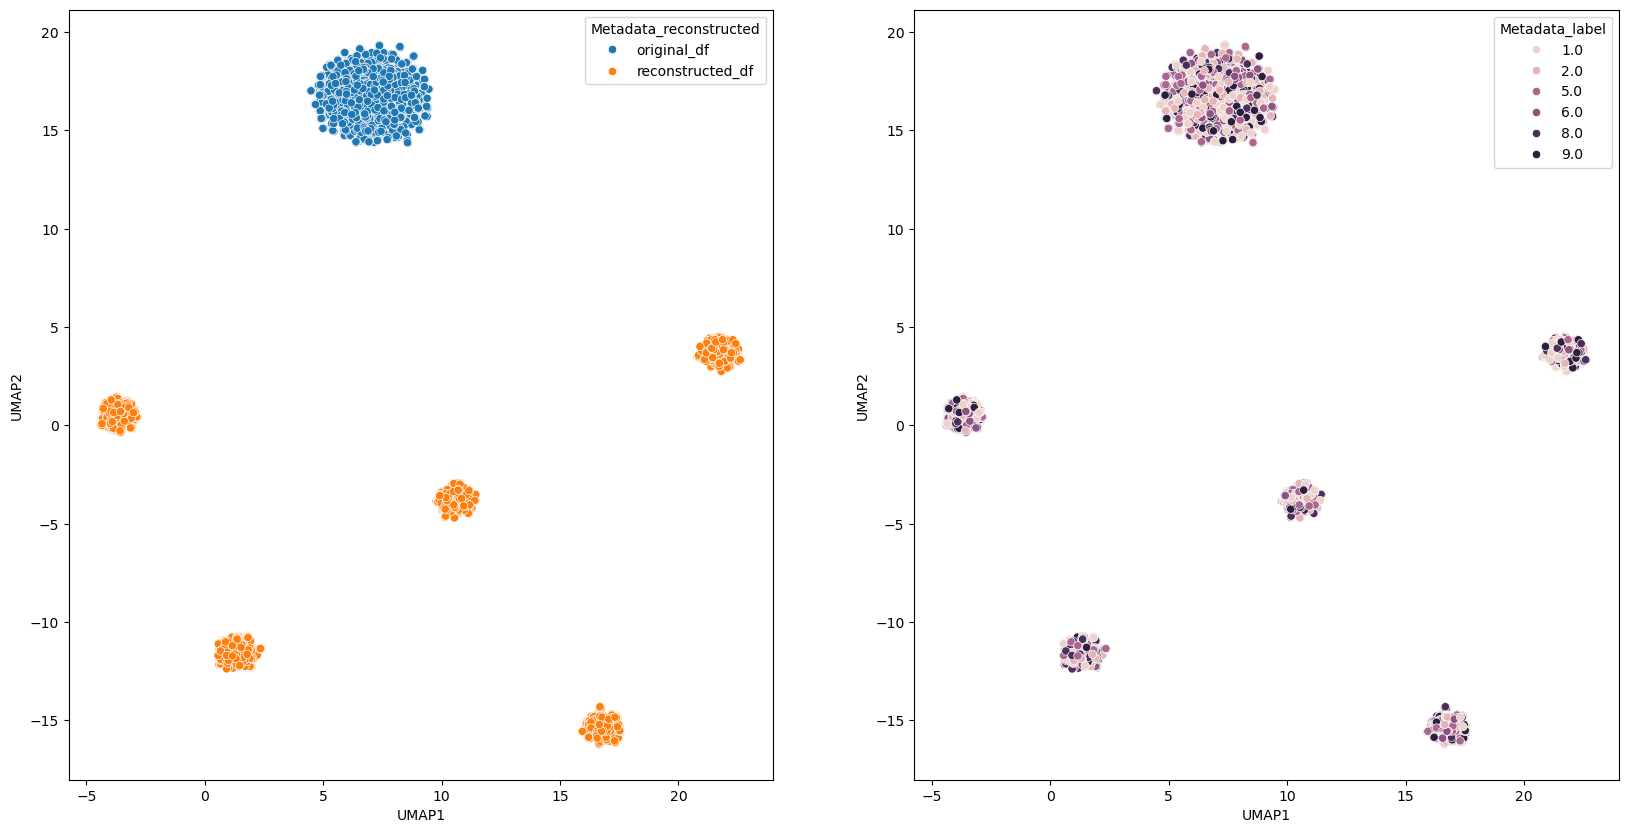

In [17]:
# plot the umap
import matplotlib.pyplot as plt
import seaborn as sns

# randomize the rows for plotting
embedding_df = embedding_df.sample(frac=1)
# two subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(
    data=embedding_df, x="UMAP1", y="UMAP2", hue="Metadata_reconstructed", ax=ax[0]
)
sns.scatterplot(data=embedding_df, x="UMAP1", y="UMAP2", hue="Metadata_label", ax=ax[1])
plt.show()